# Example of a two-dimensional constrained Gaussian Process

In [1]:
import torch
import gpytorch
from src.models.constrained_gp_model import ConstrainedGPAgrell
import matplotlib.pyplot as plt

In [2]:
# Objective function
def objective_func(x1, x2):
    return 0.4 * torch.square(x1) +0.4 * torch.square(x2) - 6

/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


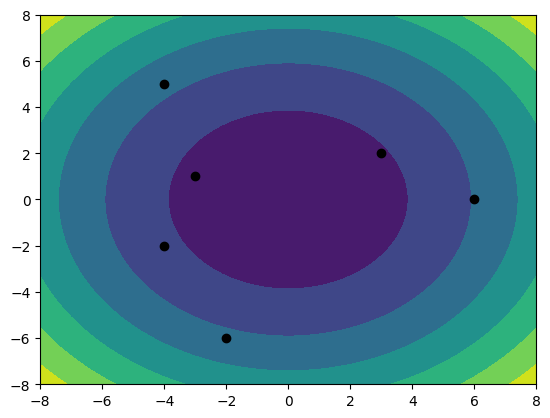

In [3]:
noise = 0.1

# define train points
x_train = torch.Tensor([[-2, -6], [3, 2], [-4, -2], [-3, 1], [6, 0], [-4, 5]])
y_train = objective_func(x_train[:, 0], x_train[:, 1]) + torch.normal(mean=0, std=torch.ones_like(x_train[:, 0])*noise,)


X = torch.linspace(-8, 8, 50)
Y = torch.linspace(-8, 8, 50)

X, Y = torch.meshgrid(X, Y)
Z = objective_func(X, Y)

fig = plt.figure()
plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.show()
plt.close()

In [4]:
X1_test, X2_test = X.reshape(-1, 1), Y.reshape(-1, 1)
X_test = torch.cat((X1_test, X2_test), dim=1)
print(X_test.shape)

torch.Size([2500, 2])


In [49]:
constrained_dims = [] # list of constrained dimensions
unconstrained_dims = [0, 1] # list of unconstrained dimensions

model_unconstrained = ConstrainedGPAgrell(
    x_train,
    y_train,
    constrained_dims=constrained_dims,
    unconstrained_dims=unconstrained_dims,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(2, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(1, 2),
    prior_mean=-2.)
model_unconstrained.likelihood.noise_covar.noise = noise ** 2

In [50]:
# unconstrained GP
prediction_unconstrained = model_unconstrained.posterior(X=X_test)
unconstrained_mean = prediction_unconstrained.mean.detach().numpy().reshape(-1)
unconstrained_std = torch.sqrt(prediction_unconstrained.variance.detach()).numpy().reshape(-1)


In [54]:
constrained_dims = [1] # list of constrained dimensions
unconstrained_dims = [0] # list of unconstrained dimensions

model_constrained = ConstrainedGPAgrell(
    x_train,
    y_train,
    constrained_dims=constrained_dims,
    unconstrained_dims=unconstrained_dims,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(2, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(1, 2),
    prior_mean=-2.)
model_constrained.likelihood.noise_covar.noise = noise ** 2


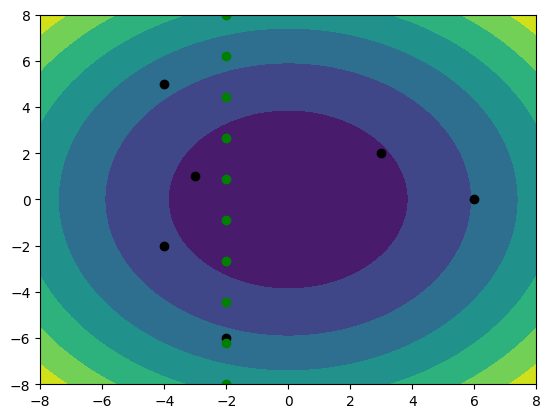

In [55]:
# define virtual observation locations
xv_points = torch.linspace(-8, 8, 10).reshape(-1, 1)
dummy_dim = torch.zeros(xv_points.shape[0]).reshape(-1, 1)

if constrained_dims[0]==1:
    xv_points = torch.cat((dummy_dim-2, xv_points), dim=1)
else:
    xv_points = torch.cat((xv_points, dummy_dim-2), dim=1)

fig = plt.figure()
plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.plot(xv_points[:, 0].numpy(), xv_points[:, 1].numpy(), 'go', label='Virtual observation points')
plt.show()
plt.close()

In [56]:
posterior_options = {'evaluate_constrained': True,
                     'virtual_oberservation_points': xv_points,
                     'nr_samples': 1000}

# constrained GP
prediction_constrained = model_constrained.posterior(X=X_test, observation_noise=False, **posterior_options)
constrained_mean = prediction_constrained.mean.detach().numpy().reshape(-1)
constrained_std = torch.sqrt(prediction_constrained.variance.detach()).numpy().reshape(-1)

Start minimax algorithm (Python implementation) for 1000 samples (D=10)...
Time taken for 1000 samples: 0.01s.


In [57]:
# get samples from unconstrained model
samples_unconstrained = model_unconstrained.get_samples_from_last_posterior(3)

# get samples from constrained model
samples_constrained = model_constrained.get_samples_from_last_posterior(3)

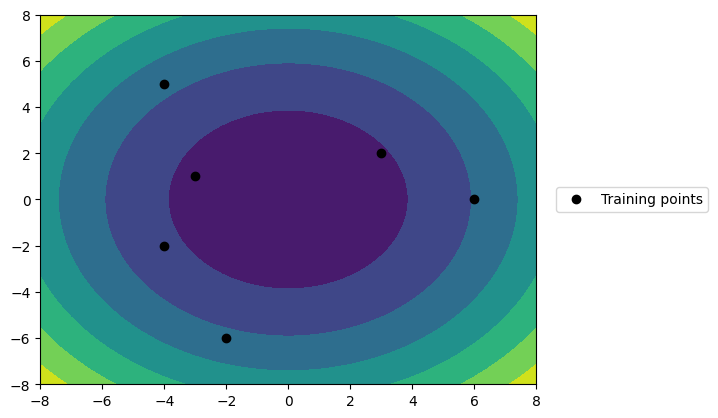

In [58]:
plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

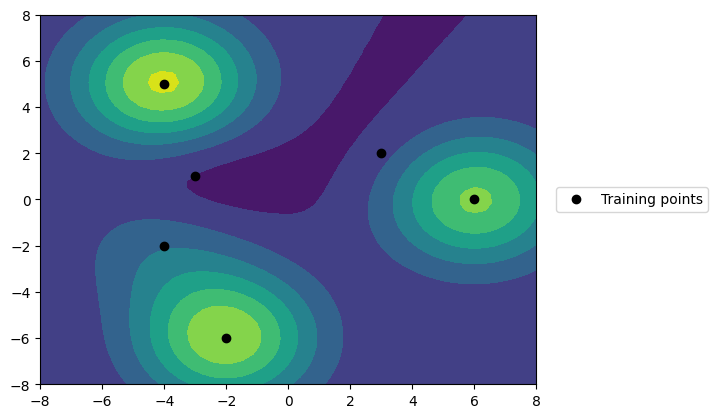

In [59]:
# unconstrained posterior
plt.contourf(X.numpy(), Y.numpy(), unconstrained_mean.reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

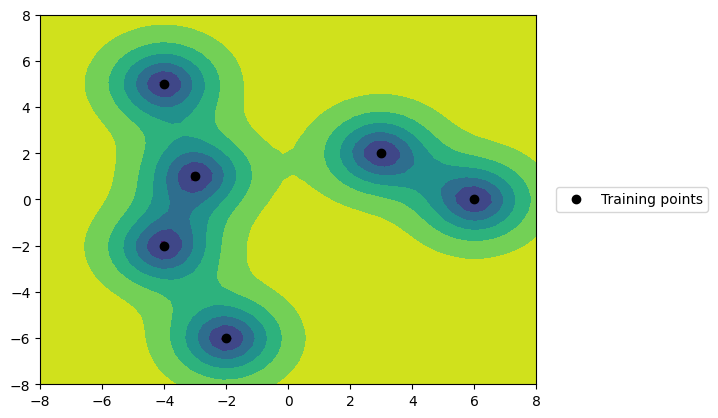

In [60]:
# unconstrained posterior stdv
plt.contourf(X.numpy(), Y.numpy(), unconstrained_std.reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

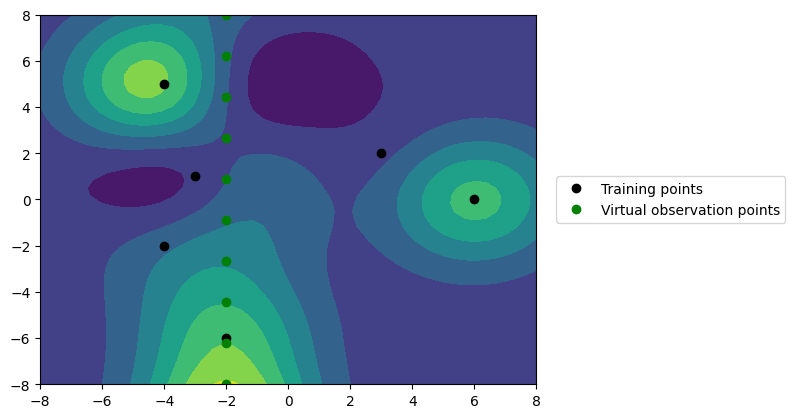

In [61]:
# constrained posterior
plt.contourf(X.numpy(), Y.numpy(), constrained_mean.reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.plot(xv_points[:, 0].numpy(), xv_points[:, 1].numpy(), 'go', label='Virtual observation points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

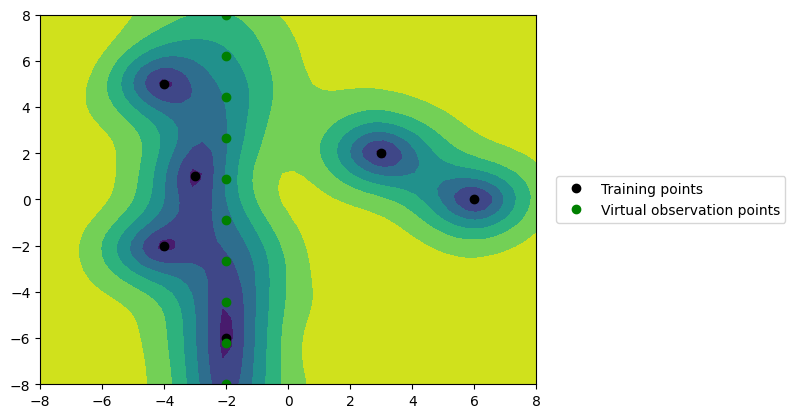

In [63]:
# constrained posterior stdv
plt.contourf(X.numpy(), Y.numpy(), constrained_std.reshape(50, 50), cmap='viridis')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), 'ko', label='Training points')
plt.plot(xv_points[:, 0].numpy(), xv_points[:, 1].numpy(), 'go', label='Virtual observation points')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()